In [1]:
from pathlib import Path
from typing import Tuple

import cv2
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import extension as ext
from extension import utils
from segmentation.networks.SemanticSAM import semantic_sam_l, semantic_sam_t
from segmentation.tree_segmentation.util import color_mask, show_masks, image_add_points, image_add_mask_boundary


2023-07-18 21:12:44.084473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 21:12:45.245496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-07-18 21:12:45.245656: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline
torch.set_grad_enabled(False)

2.0.1+cu117


In [3]:
ckpt_path = Path("~/models/segmentation/Semantic-SAM/swinl_only_sam_many2many.pth").expanduser()
model = semantic_sam_l(ckpt_path).eval().cuda()
device = torch.device('cuda')
print('model')

/home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Do not load pretrained models
model


In [33]:
from detectron2.structures import ImageList
from extension.utils import retry_if_cuda_oom
from segmentation.networks.SemanticSAM import sem_seg_postprocess


def remove_small_regions(mask: np.ndarray, area_thresh: float, mode: str) -> Tuple[np.ndarray, bool]:
    """
    Removes small disconnected regions and holes in a mask. Returns the
    mask and an indicator of if the mask has been modified.
    """
    import cv2  # type: ignore

    assert mode in ["holes", "islands"]
    correct_holes = mode == "holes"
    working_mask = (correct_holes ^ mask).astype(np.uint8)
    n_labels, regions, stats, _ = cv2.connectedComponentsWithStats(working_mask, 8)
    sizes = stats[:, -1][1:]  # Row 0 is background label
    small_regions = [i + 1 for i, s in enumerate(sizes) if s < area_thresh]
    if len(small_regions) == 0:
        return mask, False
    fill_labels = [0] + small_regions
    if not correct_holes:
        fill_labels = [i for i in range(n_labels) if i not in fill_labels]
        # If every region is below threshold, keep largest
        if len(fill_labels) == 0:
            fill_labels = [int(np.argmax(sizes)) + 1]
    mask = np.isin(regions, fill_labels)
    return mask, True


def interactive_infer_image(
    model: nn.Module,
    image: np.ndarray,
    points,
    all_classes='',
    all_parts='',
    iou_threshold=0.5,
    min_size=None,
    max_size=None,
    hole_scale=100,
    island_scale=100,
):
    H_, W_, _ = image.shape
    if min_size is not None:
        scale = max(max(min_size / H_, min_size / W_), 1)
        H, W = int(scale * H_), int(scale * W_)
    elif max_size is not None:
        scale = min(min(max_size / H_, max_size / W_), 1.)
        # print('scale=', scale)
        H, W = int(scale * H_), int(scale * W_)
    else:
        H, W = H_, W_
    print(f'resize image: {W_, H_} -> {W, H}')
    image_ori = cv2.resize(image, (W, H))
    images = torch.from_numpy(image_ori.copy()).permute(2, 0, 1).cuda()
    images = (images.to(model.device) - model.pixel_mean) / model.pixel_std
    if model.size_divisibility > 1:
        Wp, Hp = utils.make_divisible(W, model.size_divisibility), utils.make_divisible(H, model.size_divisibility)
        if Wp != W or Hp != H:
            images = F.pad(images, (0, Wp - W, 0, Hp - H), "constant", 0)
        print(f'image shape after pad: {images.shape}, before {W, H}')
    else:
        Wp, Hp = W, H

    points = torch.from_numpy(points).float().to(images.device)
    print(points)
    if len(points) == 0:
        point = points.new_tensor([[0.5, 0.5, 0.006, 0.006]])
    else:
        point_ = points.mean(0)[None]
        point = point_.clone()
        point[0, 0] = point_[0, 0] / W_
        point[0, 1] = point_[0, 1] / H_
        # point = point[:, [1, 0]]
        point = torch.cat([point, points.new_tensor([[0.005, 0.005]])], dim=-1)
    print('point:', point)
    targets = [{'points': point, 'pb': point.new_tensor([0.])}]
    # data['targets'] = [dict()]
    # data['targets'][0]['points'] = point
    # data['targets'][0]['pb'] = point.new_tensor([0.])

    # masks, ious = model.evaluate_demo(batch_inputs, all_classes, all_parts)
    ########### begin evaluate_demo ###################3

    # images = ImageList.from_tensors(images, model.size_divisibility)
    features = model.backbone(images[None])
    # batch inputs: point_coords
    prediction_switch = {'part': False, 'whole': False, 'seg': True, 'det': True}
    # targets = data['targets']
    targets[0]['points'] = targets[0]['points'] * torch.as_tensor(
        [W, H, W, H], dtype=torch.float, device=model.device) / torch.as_tensor(
        [Wp, Hp, Wp, Hp], dtype=torch.float, device=model.device)

    mask_features, transformer_encoder_features, multi_scale_features = model.sem_seg_head.pixel_decoder.forward_features(
        features, None)

    outputs, mask_dict = model.sem_seg_head.predictor(multi_scale_features, mask_features, None, targets=targets,
        target_queries=None, target_vlp=None, task='demo', extra=prediction_switch)
    # outputs, mask_dict = model.sem_seg_head(features, targets=targets, task='demo', extra=prediction_switch)

    ious = None
    if 'pred_ious' in outputs.keys():
        ious = outputs["pred_ious"]

    mask_pred_results = outputs["pred_masks"]
    # upsample masks
    mask_pred_results = F.interpolate(
        mask_pred_results,
        size=(images.shape[-2], images.shape[-1]),
        mode="bilinear",
        align_corners=False,
    )

    print(utils.show_shape(mask_pred_results), (Wp, Hp))
    masks = F.interpolate(mask_pred_results[:, :, :H, :W], size=(H_, W_), mode='bilinear')[0]
    print('outputs:', utils.show_shape(masks, ious))
    print('ious:', ious)
    ############### end evaluate_demo ###################

    pred_masks_poses = masks
    reses = []
    ious = ious[0, 0]
    ids = torch.argsort(ious, descending=True)

    mask_ls = []
    ious_res = []
    areas = []
    for i, (pred_masks_pos, iou) in enumerate(zip(pred_masks_poses[ids], ious[ids])):
        iou = round(float(iou), 2)
        mask = (pred_masks_pos > 0.0).cpu().numpy()
        area = mask.sum()
        conti = False
        if iou < iou_threshold:
            conti = True
        for m in mask_ls:
            if np.logical_and(mask, m).sum() / np.logical_or(mask, m).sum() > 0.95:
                conti = True
                break
        if i == len(pred_masks_poses[ids]) - 1 and mask_ls == []:
            conti = False
        if conti:
            continue
        ious_res.append(iou)
        mask_ls.append(mask)
        areas.append(area)
        mask, _ = remove_small_regions(mask, int(hole_scale), mode="holes")
        mask, _ = remove_small_regions(mask, int(island_scale), mode="islands")
        reses.append(mask)
    ids = list(torch.argsort(torch.tensor(areas), descending=False))
    ids = [int(i) for i in ids]

    torch.cuda.empty_cache()

    return reses, [reses[i] for i in ids]


image: numpy((900, 1200, 3), uint8)


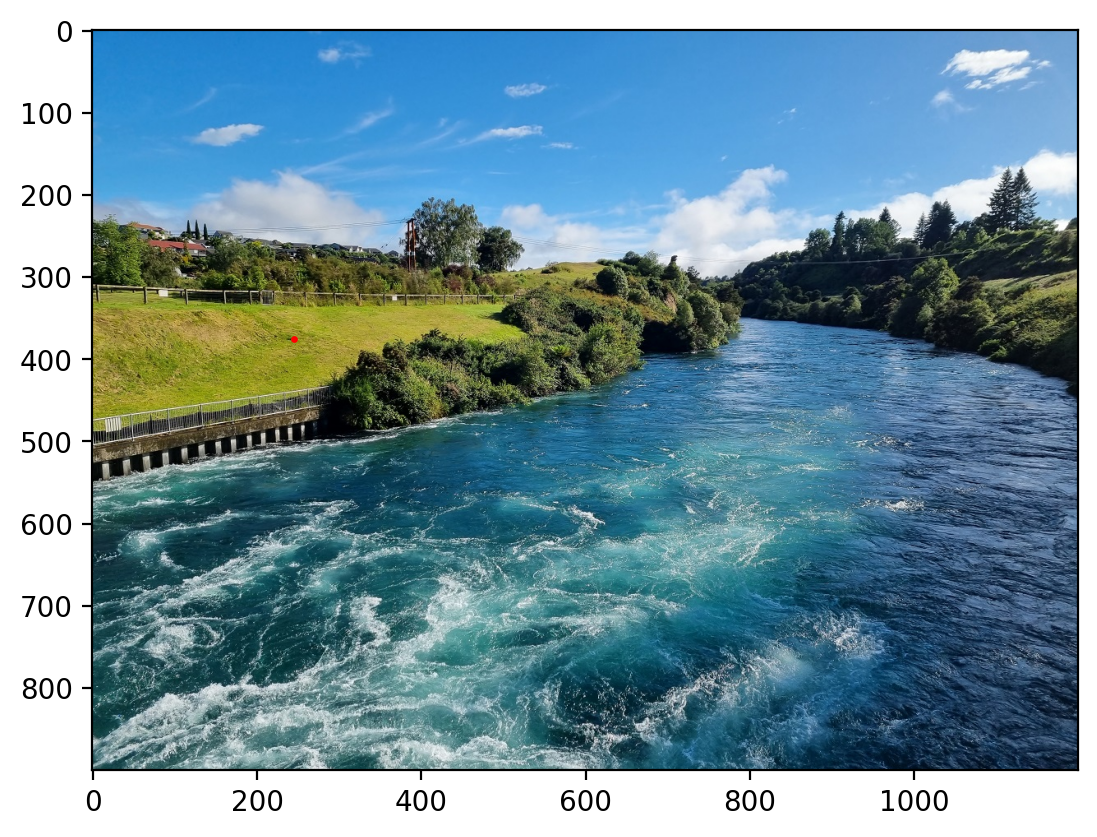

In [41]:
# image_path = Path('/home/wan/Pictures/cat_2.jpg')
image_path = Path('/home/wan/Projects/Segmentation/Semantic-SAM/examples/river2.png')
image = utils.load_image(image_path)
print('image:', utils.show_shape(image))
plt.figure(dpi=200)
plt.imshow(image)
points = [245, 375]
plt.scatter(points[0], points[1], s=2, c='red')

resize image: (1200, 900) -> (1024, 768)
image shape after pad: torch.Size([3, 768, 1024]), before (1024, 768)
tensor([[245., 375.]], device='cuda:0')
point: tensor([[0.2042, 0.4167, 0.0050, 0.0050]], device='cuda:0')
F16Tensor[1, 6, 768, 1024] (1024, 768)
outputs: F16Tensor[6, 900, 1200], F16Tensor[1, 1, 6]
ious: tensor([[[0.8613, 0.9863, 0.8828, 0.8916, 0.9053, 0.8438]]], device='cuda:0',
       dtype=torch.float16)
numpy((900, 1200, 3), uint8), [numpy((900, 1200), bool), numpy((900, 1200), bool), numpy((900, 1200), bool), numpy((900, 1200), bool)], [numpy((900, 1200), bool), numpy((900, 1200), bool), numpy((900, 1200), bool), numpy((900, 1200), bool)]


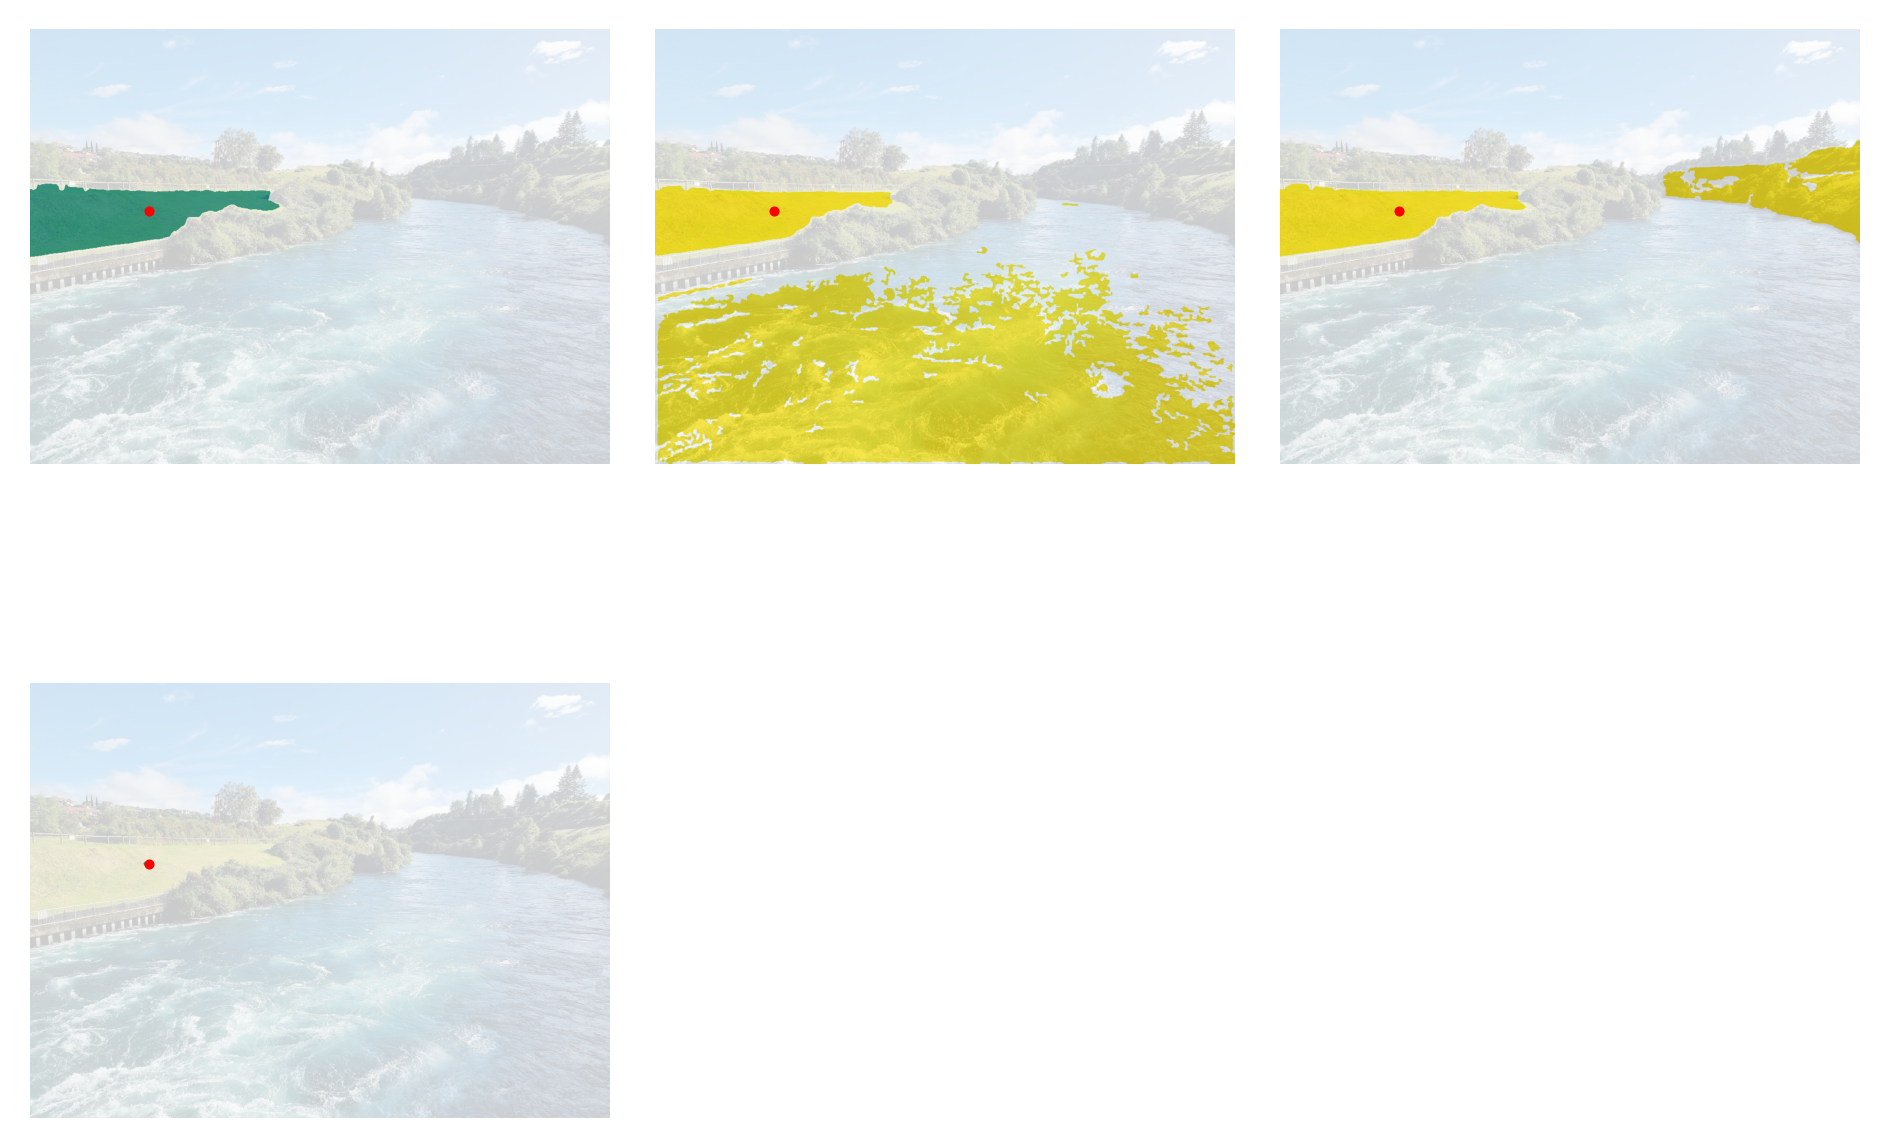

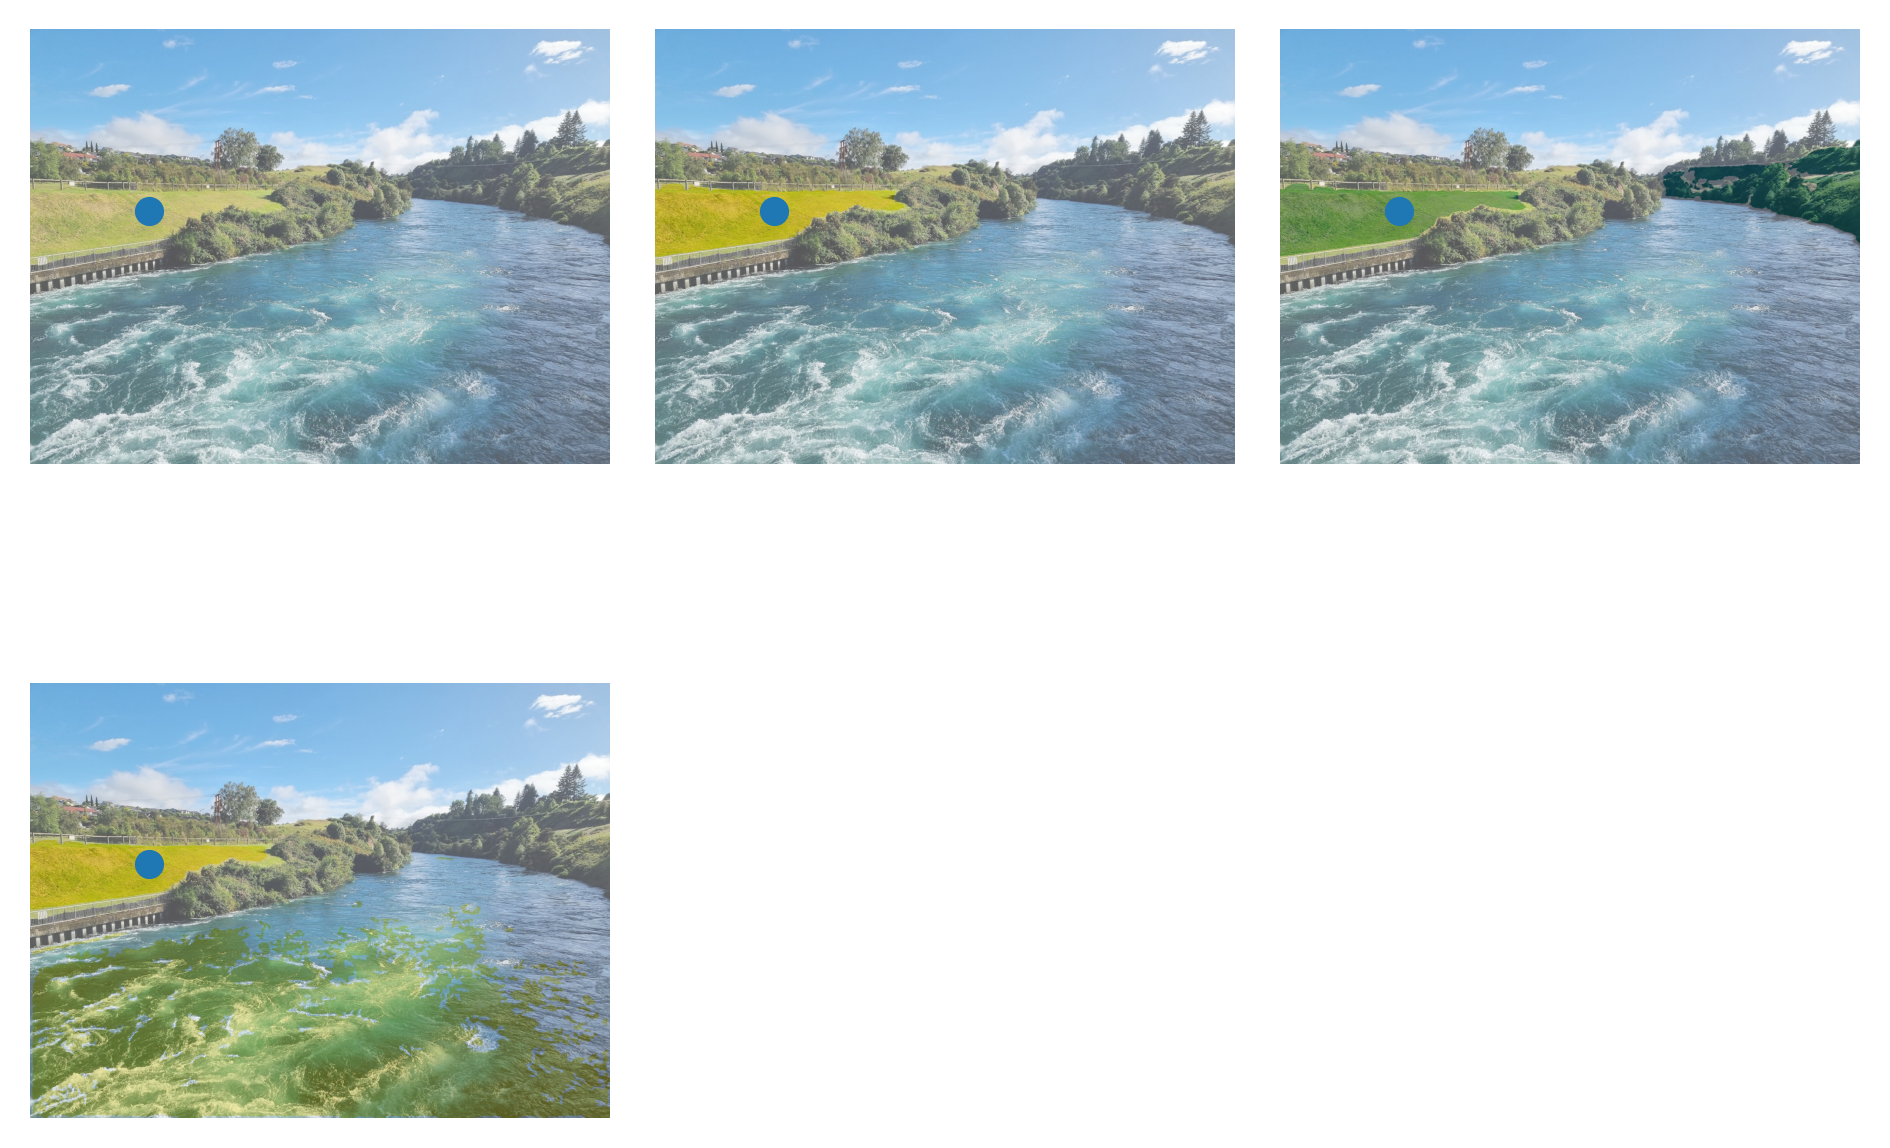

In [44]:
with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
    results_a, results_b = interactive_infer_image(model,
        image,
        np.array([points]),
        max_size=1024,
        all_classes='',
        all_parts='',
        # 0.5,
        # 1024,
        # 100,
        # 100
    )
print(utils.show_shape(image, results_a, results_b))
N = len(results_a)
plt.figure(dpi=300)
for i in range(N):
    plt.subplot(2, 3, i + 1)
    # plt.imshow(results_a[i])
    show_masks(image, mask=results_a[i], alpha=0.8)
    plt.scatter(points[0], points[1], s=2, c='red')
    plt.axis('off')
plt.tight_layout()
plt.show()
N = len(results_b)
plt.figure(dpi=300)
for i in range(N):
    plt.subplot(2, 3, i + 1)
    # plt.imshow(results_b[i])
    show_masks(image, mask=results_b[i])
    plt.scatter(points[0], points[1])
    plt.axis('off')
plt.tight_layout()
plt.show()
# print(results_a, results_b)

resize image: (1600, 900) -> (1600, 900)
tensor([[300., 200.]], device='cuda:0')
point: tensor([[0.1875, 0.2222, 0.0050, 0.0050]], device='cuda:0')
image shape after pad: torch.Size([3, 928, 1600]), before (1600, 900)
F16Tensor[1, 6, 928, 1600] (1600, 928)
outputs: F16Tensor[6, 900, 1600], F16Tensor[1, 1, 6]
ious: tensor([[[0.9893, 0.7192, 0.5957, 0.9790, 0.9614, 0.4080]]], device='cuda:0',
       dtype=torch.float16)
numpy((900, 1600, 3), uint8), [numpy((900, 1600), bool), numpy((900, 1600), bool), numpy((900, 1600), bool), numpy((900, 1600), bool), numpy((900, 1600), bool)], [numpy((900, 1600), bool), numpy((900, 1600), bool), numpy((900, 1600), bool), numpy((900, 1600), bool), numpy((900, 1600), bool)]


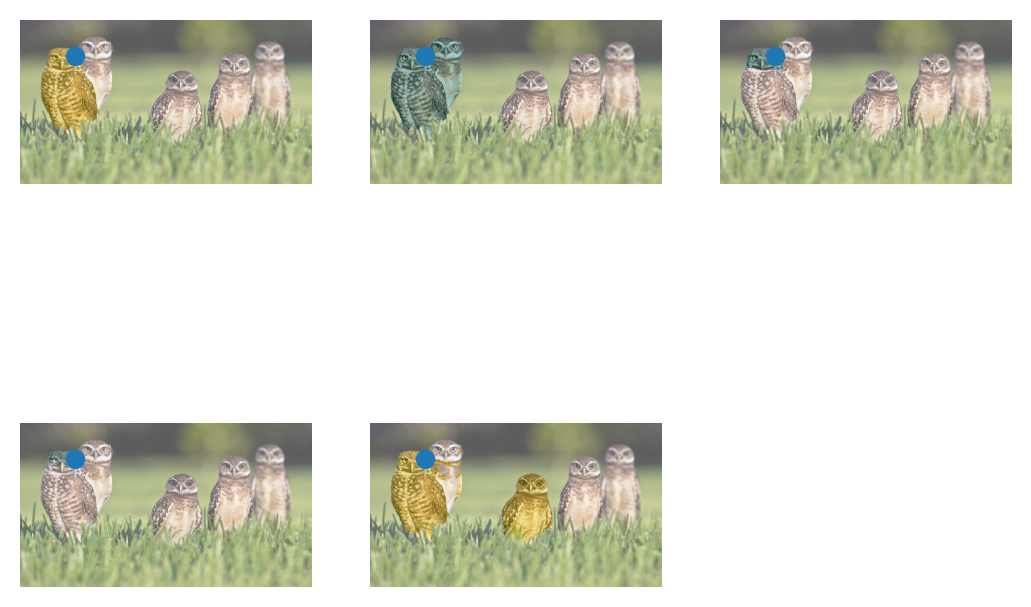

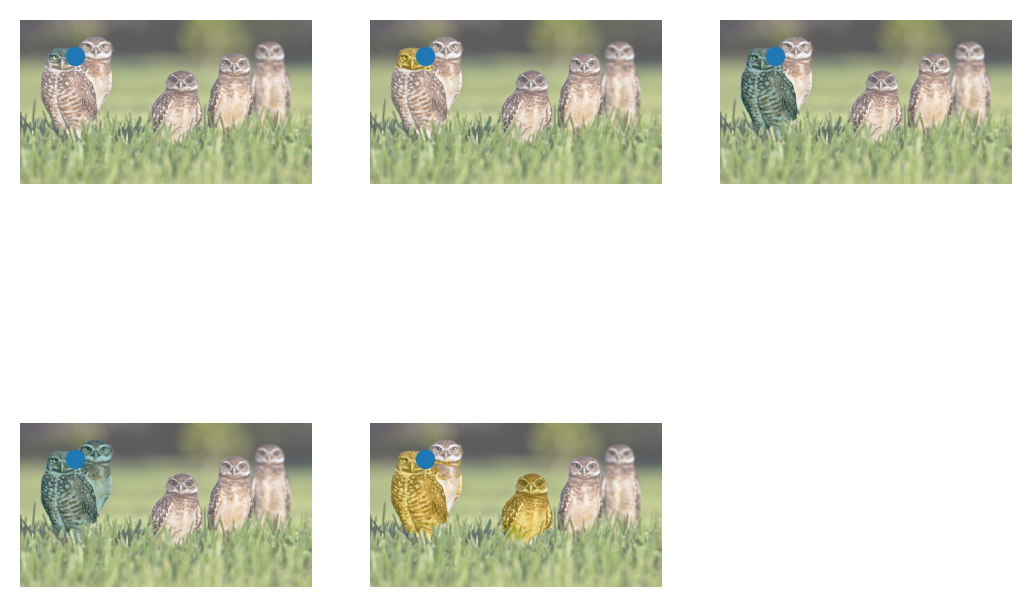

In [23]:
with torch.no_grad(), torch.autocast(device_type='cuda', dtype=torch.float16):
    results_a, results_b = interactive_infer_image(model,
        image,
        np.array([points]),
        max_size=1024,
        all_classes='',
        all_parts='',
        # 0.5,
        # 1024,
        # 100,
        # 100
    )
print(utils.show_shape(image, results_a, results_b))
N = len(results_a)
plt.figure(dpi=200)
for i in range(N):
    plt.subplot(2, 3, i + 1)
    # plt.imshow(results_a[i])
    show_masks(image, mask=results_a[i])
    plt.scatter(points[0], points[1])
    plt.axis('off')
plt.show()
N = len(results_b)
plt.figure(dpi=200)
for i in range(N):
    plt.subplot(2, 3, i + 1)
    # plt.imshow(results_b[i])
    show_masks(image, mask=results_b[i])
    plt.scatter(points[0], points[1])
    plt.axis('off')
plt.show()
# print(results_a, results_b)